In [1]:
import os
import sys
from typing import Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_validate

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    roc_auc_score, f1_score, precision_score, recall_score,
    confusion_matrix, classification_report, roc_curve,
    precision_recall_curve, brier_score_loss
)

from xgboost import XGBClassifier

# modules
from src.config import (
    OUTPUT_DIR,
    PROCESSED_DIR,
    FIGURES_DIR,
    RANDOM_SEED,
    Color
)

# vis config 
plt.style.use('default')
sns.set_palette("husl")
FIGSIZE = (10, 6)
FIGSIZE_SMALL = (8, 5)

In [2]:
print("=" * 80)
print("LOADING PIPELINE A DATA")
print("=" * 80)

# load processed data
X_train_A = np.load(PROCESSED_DIR / 'X_train_A.npy')
X_test_A = np.load(PROCESSED_DIR / 'X_test_A.npy')
y_train = np.load(PROCESSED_DIR / 'y_train.npy')
y_test = np.load(PROCESSED_DIR / 'y_test.npy')

# load feature names
with open(PROCESSED_DIR / 'feature_names_A.txt', 'r') as f:
    feature_names_A = f.read().split(r'\n')

# validation
print(f"\nShapes:")
print(f"  X_train_A: {X_train_A.shape}")
print(f"  X_test_A:  {X_test_A.shape}")
print(f"  y_train:   {y_train.shape}")
print(f"  y_test:    {y_test.shape}")

print(f"\nFeatures ({len(feature_names_A)}):")
print(f"  {feature_names_A}")

# check for missing values
print(f"\nData Quality:")
print(f"  X_train_A missing: {np.isnan(X_train_A).sum()}")
print(f"  X_test_A missing:  {np.isnan(X_test_A).sum()}")

# class distribution
unique, counts = np.unique(y_train, return_counts=True)
print(f"\nClass Distribution (Training):")
for label, count in zip(unique, counts):
    print(f"  Class {label}: {count:,} ({count/len(y_train)*100:.2f}%)")

print("\nPipeline A data loaded successfully")

LOADING PIPELINE A DATA

Shapes:
  X_train_A: (20000, 8)
  X_test_A:  (5000, 8)
  y_train:   (20000,)
  y_test:    (5000,)

Features (8):
  ['Age', 'Income', 'CreditScore', 'LoanAmount', 'EmploymentYears', 'NumDependents', 'DebtToIncome', 'EducationLevel']

Data Quality:
  X_train_A missing: 0
  X_test_A missing:  0

Class Distribution (Training):
  Class 0: 13,137 (65.69%)
  Class 1: 6,863 (34.31%)

Pipeline A data loaded successfully


In [3]:
print("=" * 80)
print("LOADING PIPELINE B DATA")
print("=" * 80)

# load processed data
X_train_B = np.load(PROCESSED_DIR / 'X_train_B.npy')
X_test_B = np.load(PROCESSED_DIR / 'X_test_B.npy')

# load feature names
with open(PROCESSED_DIR / 'feature_names_B.txt', 'r') as f:
    feature_names_B = f.read().split(r'\n')

# validation
print(f"\nShapes:")
print(f"  X_train_B: {X_train_B.shape}")
print(f"  X_test_B:  {X_test_B.shape}")

print(f"\nFeatures ({len(feature_names_B)}):")
for i, feat in enumerate(feature_names_B):
    print(f"  {i+1:2d}. {feat}")

# check for missing values
print(f"\nData Quality:")
print(f"  X_train_B missing: {np.isnan(X_train_B).sum()}")
print(f"  X_test_B missing:  {np.isnan(X_test_B).sum()}")

print("\nPipeline B data loaded successfully")

LOADING PIPELINE B DATA

Shapes:
  X_train_B: (20000, 14)
  X_test_B:  (5000, 14)

Features (14):
   1. Age
   2. Income
   3. CreditScore
   4. LoanAmount
   5. EmploymentYears
   6. NumDependents
   7. DebtToIncome
   8. EducationLevel
   9. FavoriteColor_Green
  10. FavoriteColor_Red
  11. FavoriteColor_Yellow
  12. Hobby_Reading
  13. Hobby_Sports
  14. Hobby_Traveling

Data Quality:
  X_train_B missing: 0
  X_test_B missing:  0

Pipeline B data loaded successfully


In [4]:
print("=" * 80)
print("CROSS-VALIDATION SETUP")
print("=" * 80)

# create stratified k-fold
N_SPLITS = 5
RANDOM_STATE = 42

cv = StratifiedKFold(
    n_splits=N_SPLITS,
    shuffle=True,
    random_state=RANDOM_STATE
)

# verify stratification
print(f"\nCross-Validation Configuration:")
print(f"  Strategy: Stratified K-Fold")
print(f"  Splits: {N_SPLITS}")
print(f"  Shuffle: True")
print(f"  Random State: {RANDOM_STATE}")

# check fold class distribution
print(f"\nVerifying stratification:")
fold_distributions = []
for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X_train_A, y_train)):
    y_fold = y_train[val_idx]
    default_rate = (y_fold == 1).sum() / len(y_fold)
    fold_distributions.append(default_rate)
    print(f"  Fold {fold_idx + 1}: {default_rate*100:.2f}% default rate")

print(f"\nStratification Quality:")
print(f"  Mean default rate: {np.mean(fold_distributions)*100:.2f}%")
print(f"  Std default rate:  {np.std(fold_distributions)*100:.3f}%")
print(f"  Target (from train): {(y_train==1).sum()/len(y_train)*100:.2f}%")

print("\nCross-validation setup complete")

CROSS-VALIDATION SETUP

Cross-Validation Configuration:
  Strategy: Stratified K-Fold
  Splits: 5
  Shuffle: True
  Random State: 42

Verifying stratification:
  Fold 1: 34.30% default rate
  Fold 2: 34.30% default rate
  Fold 3: 34.33% default rate
  Fold 4: 34.33% default rate
  Fold 5: 34.33% default rate

Stratification Quality:
  Mean default rate: 34.31%
  Std default rate:  0.012%
  Target (from train): 34.31%

Cross-validation setup complete


In [5]:
print("=" * 80)
print("EVALUATION METRICS SETUP")
print("=" * 80)

all_results = {}

# define scoring metrics for cross-validation
SCORING_METRICS = {
    'roc_auc': 'roc_auc',
    'f1': 'f1',
    'precision': 'precision',
    'recall': 'recall',
    'accuracy': 'accuracy'
}

print("\nMetrics for evaluation:")
print("  Primary:   ROC-AUC (threshold-independent, handles imbalance)")
print("  Secondary: F1, Precision, Recall (threshold-dependent)")
print("  Additional: Accuracy, Brier Score (calibration)")

# helper function for consistent evaluation
def evaluate_model(
    model,
    X_train, y_train,
    X_test, y_test,
    cv,
    model_name: str,
    pipeline_name: str
) -> Dict:
    """
    Comprehensive model evaluation with CV and test set metrics.
    
    Returns:
        Dictionary with CV scores, test scores, and predictions
    """
    
    # CV
    cv_results = cross_validate(
        model, X_train, y_train,
        cv=cv,
        scoring=SCORING_METRICS,
        return_train_score=False,
        n_jobs=-1
    )
    
    # test set predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # test set metrics
    test_metrics = {
        'roc_auc': roc_auc_score(y_test, y_pred_proba),
        'f1': f1_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'accuracy': (y_pred == y_test).mean(),
        'brier': brier_score_loss(y_test, y_pred_proba)
    }
    
    results = {
        'model_name': model_name,
        'pipeline': pipeline_name,
        'cv_scores': cv_results,
        'test_metrics': test_metrics,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'model': model
    }
    
    return results


EVALUATION METRICS SETUP

Metrics for evaluation:
  Primary:   ROC-AUC (threshold-independent, handles imbalance)
  Secondary: F1, Precision, Recall (threshold-dependent)
  Additional: Accuracy, Brier Score (calibration)


In [6]:
print("=" * 80)
print("MODEL 1/8: DUMMY CLASSIFIER - PIPELINE A")
print("=" * 80)

# create and train dummy classifier
dummy_A = DummyClassifier(strategy='stratified', random_state=RANDOM_SEED)
dummy_A.fit(X_train_A, y_train)

# evaluate
results_dummy_A = evaluate_model(
    model=dummy_A,
    X_train=X_train_A,
    y_train=y_train,
    X_test=X_test_A,
    y_test=y_test,
    cv=cv,
    model_name='DummyClassifier',
    pipeline_name='A'
)

# store results
all_results['dummy_A'] = results_dummy_A

# display results
print("\nCross-Validation Results (5-fold):")
for metric in ['roc_auc', 'f1', 'precision', 'recall', 'accuracy']:
    scores = results_dummy_A['cv_scores'][f'test_{metric}']
    print(f"  {metric:12s}: {scores.mean():.4f} ± {scores.std():.4f}")

print("\nTest Set Results:")
for metric, value in results_dummy_A['test_metrics'].items():
    print(f"  {metric:12s}: {value:.4f}")

print("\nModel 1/8 complete")

MODEL 1/8: DUMMY CLASSIFIER - PIPELINE A

Cross-Validation Results (5-fold):
  roc_auc     : 0.5016 ± 0.0083
  f1          : 0.3451 ± 0.0108
  precision   : 0.3452 ± 0.0108
  recall      : 0.3450 ± 0.0108
  accuracy    : 0.5506 ± 0.0075

Test Set Results:
  roc_auc     : 0.5116
  f1          : 0.3621
  precision   : 0.3675
  recall      : 0.3568
  accuracy    : 0.5574
  brier       : 0.4426

Model 1/8 complete


In [7]:
print("=" * 80)
print("MODEL 2/8: DUMMY CLASSIFIER - PIPELINE B")
print("=" * 80)

# create and train dummy classifier
dummy_B = DummyClassifier(strategy='stratified', random_state=RANDOM_SEED)
dummy_B.fit(X_train_B, y_train)

# evaluate
results_dummy_B = evaluate_model(
    model=dummy_B,
    X_train=X_train_B,
    y_train=y_train,
    X_test=X_test_B,
    y_test=y_test,
    cv=cv,
    model_name='DummyClassifier',
    pipeline_name='B'
)

# store results
all_results['dummy_B'] = results_dummy_B

# display results
print("\nCross-Validation Results (5-fold):")
for metric in ['roc_auc', 'f1', 'precision', 'recall', 'accuracy']:
    scores = results_dummy_B['cv_scores'][f'test_{metric}']
    print(f"  {metric:12s}: {scores.mean():.4f} ± {scores.std():.4f}")

print("\nTest Set Results:")
for metric, value in results_dummy_B['test_metrics'].items():
    print(f"  {metric:12s}: {value:.4f}")

print("\nModel 2/8 complete")

MODEL 2/8: DUMMY CLASSIFIER - PIPELINE B

Cross-Validation Results (5-fold):
  roc_auc     : 0.5016 ± 0.0083
  f1          : 0.3451 ± 0.0108
  precision   : 0.3452 ± 0.0108
  recall      : 0.3450 ± 0.0108
  accuracy    : 0.5506 ± 0.0075

Test Set Results:
  roc_auc     : 0.5116
  f1          : 0.3621
  precision   : 0.3675
  recall      : 0.3568
  accuracy    : 0.5574
  brier       : 0.4426

Model 2/8 complete


DUMMY CLASSIFIER ANALYSIS


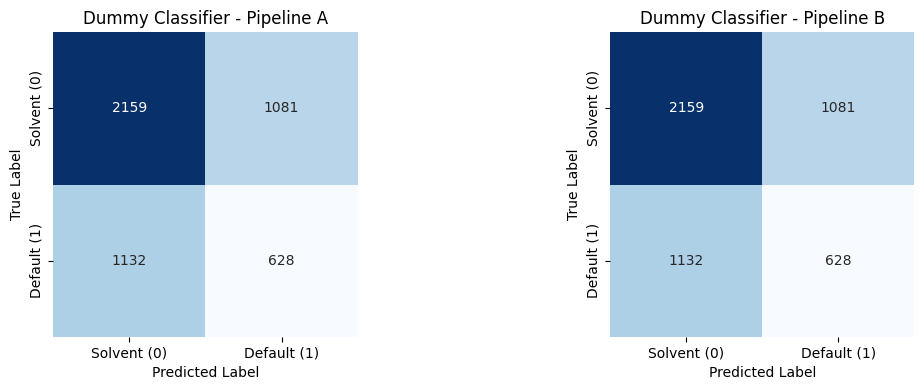


Confusion matrices saved to /Users/kryspin/personal/playground/recruitment/challengING_DS/ing_task/output/figures/03_dummy_confusion_matrices.png


In [8]:
print("=" * 80)
print("DUMMY CLASSIFIER ANALYSIS")
print("=" * 80)

# confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for idx, (key, pipeline) in enumerate([('dummy_A', 'A'), ('dummy_B', 'B')]):
    results = all_results[key]
    cm = confusion_matrix(y_test, results['y_pred'])
    
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        ax=axes[idx],
        cbar=False,
        square=True
    )
    axes[idx].set_title(f'Dummy Classifier - Pipeline {pipeline}')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')
    axes[idx].set_xticklabels(['Solvent (0)', 'Default (1)'])
    axes[idx].set_yticklabels(['Solvent (0)', 'Default (1)'])

plt.tight_layout()
plt.savefig(FIGURES_DIR / '03_dummy_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nConfusion matrices saved to {FIGURES_DIR / '03_dummy_confusion_matrices.png'}")

In [9]:
print("=" * 80)
print("DUMMY BASELINE SUMMARY")
print("=" * 80)

# compare pipelines
comparison_data = []
for key in ['dummy_A', 'dummy_B']:
    results = all_results[key]
    comparison_data.append({
        'Pipeline': results['pipeline'],
        'Model': results['model_name'],
        'ROC-AUC (CV)': f"{results['cv_scores']['test_roc_auc'].mean():.4f} ± {results['cv_scores']['test_roc_auc'].std():.4f}",
        'ROC-AUC (Test)': f"{results['test_metrics']['roc_auc']:.4f}",
        'F1 (Test)': f"{results['test_metrics']['f1']:.4f}",
        'Brier Score': f"{results['test_metrics']['brier']:.4f}"
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n" + comparison_df.to_string(index=False))

print("\n" + "=" * 80)
print("INTERPRETATION:")
print("=" * 80)
print("✓ ROC-AUC ≈ 0.50: Confirms random baseline as expected")
print("✓ Both pipelines perform identically (both random)")
print("✓ Any model with ROC-AUC > 0.55 beats random guessing")

DUMMY BASELINE SUMMARY

Pipeline           Model    ROC-AUC (CV) ROC-AUC (Test) F1 (Test) Brier Score
       A DummyClassifier 0.5016 ± 0.0083         0.5116    0.3621      0.4426
       B DummyClassifier 0.5016 ± 0.0083         0.5116    0.3621      0.4426

INTERPRETATION:
✓ ROC-AUC ≈ 0.50: Confirms random baseline as expected
✓ Both pipelines perform identically (both random)
✓ Any model with ROC-AUC > 0.55 beats random guessing


In [10]:
print("=" * 80)
print("MODEL 3/8: LOGISTIC REGRESSION - PIPELINE A")
print("=" * 80)

# create and train model
lr_A = LogisticRegression(
    max_iter=1000,
    random_state=RANDOM_SEED,
    n_jobs=-1,
    class_weight='balanced'  # handle class imbalance
)

print("Training...")
lr_A.fit(X_train_A, y_train)

# evaluate
results_lr_A = evaluate_model(
    model=lr_A,
    X_train=X_train_A,
    y_train=y_train,
    X_test=X_test_A,
    y_test=y_test,
    cv=cv,
    model_name='LogisticRegression',
    pipeline_name='A'
)

# store results
all_results['lr_A'] = results_lr_A

# display results
print("\nCross-Validation Results (5-fold):")
for metric in ['roc_auc', 'f1', 'precision', 'recall', 'accuracy']:
    scores = results_lr_A['cv_scores'][f'test_{metric}']
    print(f"  {metric:12s}: {scores.mean():.4f} ± {scores.std():.4f}")

print("\nTest Set Results:")
for metric, value in results_lr_A['test_metrics'].items():
    print(f"  {metric:12s}: {value:.4f}")

# feature coefficients
print("\nTop 5 Features (by absolute coefficient):")
coef_df = pd.DataFrame({
    'Feature': feature_names_A,
    'Coefficient': lr_A.coef_[0]
}).sort_values('Coefficient', key=abs, ascending=False)
print(coef_df.head().to_string(index=False))

print("\nModel 3/8 complete")

MODEL 3/8: LOGISTIC REGRESSION - PIPELINE A
Training...

Cross-Validation Results (5-fold):
  roc_auc     : 0.7584 ± 0.0089
  f1          : 0.6061 ± 0.0067
  precision   : 0.5360 ± 0.0083
  recall      : 0.6975 ± 0.0065
  accuracy    : 0.6889 ± 0.0070

Test Set Results:
  roc_auc     : 0.7590
  f1          : 0.6098
  precision   : 0.5362
  recall      : 0.7068
  accuracy    : 0.6816
  brier       : 0.2013

Top 5 Features (by absolute coefficient):
       Feature  Coefficient
   CreditScore    -0.884750
EducationLevel    -0.356289
           Age    -0.341260
        Income    -0.335742
    LoanAmount     0.182605

Model 3/8 complete


In [11]:
print("=" * 80)
print("MODEL 4/8: LOGISTIC REGRESSION - PIPELINE B")
print("=" * 80)

# create and train model
lr_B = LogisticRegression(
    max_iter=1000,
    random_state=RANDOM_SEED,
    n_jobs=-1,
    class_weight='balanced' # handle class imbalance
)

print("Training...")
lr_B.fit(X_train_B, y_train)

# evaluate
results_lr_B = evaluate_model(
    model=lr_B,
    X_train=X_train_B,
    y_train=y_train,
    X_test=X_test_B,
    y_test=y_test,
    cv=cv,
    model_name='LogisticRegression',
    pipeline_name='B'
)

# store results
all_results['lr_B'] = results_lr_B

# display results
print("\nCross-Validation Results (5-fold):")
for metric in ['roc_auc', 'f1', 'precision', 'recall', 'accuracy']:
    scores = results_lr_B['cv_scores'][f'test_{metric}']
    print(f"  {metric:12s}: {scores.mean():.4f} ± {scores.std():.4f}")

print("\nTest Set Results:")
for metric, value in results_lr_B['test_metrics'].items():
    print(f"  {metric:12s}: {value:.4f}")

# feature coefficients
print("\nTop 10 Features (by absolute coefficient):")
coef_df = pd.DataFrame({
    'Feature': feature_names_B,
    'Coefficient': lr_B.coef_[0]
}).sort_values('Coefficient', key=abs, ascending=False)
print(coef_df.head(10).to_string(index=False))

print("\nModel 4/8 complete")

MODEL 4/8: LOGISTIC REGRESSION - PIPELINE B
Training...

Cross-Validation Results (5-fold):
  roc_auc     : 0.7581 ± 0.0088
  f1          : 0.6053 ± 0.0060
  precision   : 0.5351 ± 0.0087
  recall      : 0.6968 ± 0.0047
  accuracy    : 0.6881 ± 0.0072

Test Set Results:
  roc_auc     : 0.7590
  f1          : 0.6122
  precision   : 0.5386
  recall      : 0.7091
  accuracy    : 0.6838
  brier       : 0.2013

Top 10 Features (by absolute coefficient):
             Feature  Coefficient
         CreditScore    -0.885315
      EducationLevel    -0.356465
                 Age    -0.341768
              Income    -0.336069
          LoanAmount     0.182685
     EmploymentYears    -0.052748
       Hobby_Reading    -0.050501
FavoriteColor_Yellow    -0.046795
   FavoriteColor_Red    -0.036583
        Hobby_Sports    -0.010476

Model 4/8 complete


LOGISTIC REGRESSION: PIPELINE A vs B COMPARISON

ROC-AUC Comparison:
  Pipeline A (CV):   0.7584 ± 0.0089
  Pipeline B (CV):   0.7581 ± 0.0088
  Difference (CV):   0.0002

  Pipeline A (Test): 0.7590
  Pipeline B (Test): 0.7590
  Difference (Test): 0.0000

Paired t-test (CV folds):
  H_0: Pipeline A = Pipeline B
  t-statistic: 1.9258
  p-value:     0.1264
  Result:      No significant difference (p > 0.05)


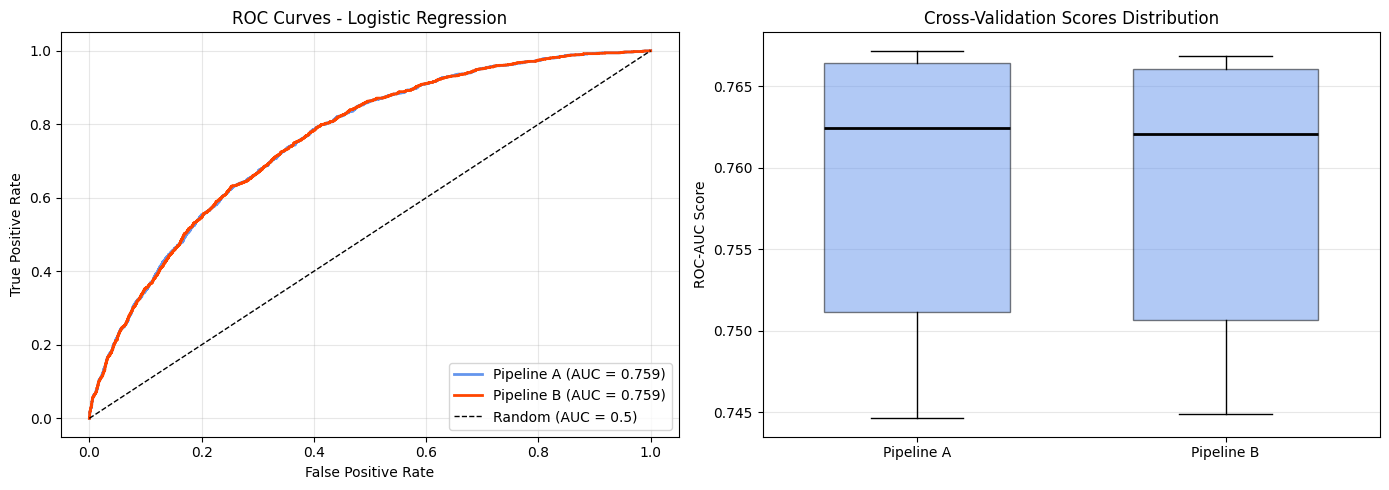


Visualization saved to /Users/kryspin/personal/playground/recruitment/challengING_DS/ing_task/output/figures/03_logistic_regression_comparison.png


In [12]:
print("=" * 80)
print("LOGISTIC REGRESSION: PIPELINE A vs B COMPARISON")
print("=" * 80)

# extract ROC-AUC scores
auc_A_cv = results_lr_A['cv_scores']['test_roc_auc']
auc_B_cv = results_lr_B['cv_scores']['test_roc_auc']
auc_A_test = results_lr_A['test_metrics']['roc_auc']
auc_B_test = results_lr_B['test_metrics']['roc_auc']

print("\nROC-AUC Comparison:")
print(f"  Pipeline A (CV):   {auc_A_cv.mean():.4f} ± {auc_A_cv.std():.4f}")
print(f"  Pipeline B (CV):   {auc_B_cv.mean():.4f} ± {auc_B_cv.std():.4f}")
print(f"  Difference (CV):   {abs(auc_A_cv.mean() - auc_B_cv.mean()):.4f}")
print(f"\n  Pipeline A (Test): {auc_A_test:.4f}")
print(f"  Pipeline B (Test): {auc_B_test:.4f}")
print(f"  Difference (Test): {abs(auc_A_test - auc_B_test):.4f}")

# statistical test: Paired t-test on CV folds
from scipy.stats import ttest_rel
t_stat, p_value = ttest_rel(auc_A_cv, auc_B_cv)

print(f"\nPaired t-test (CV folds):")
print(f"  H_0: Pipeline A = Pipeline B")
print(f"  t-statistic: {t_stat:.4f}")
print(f"  p-value:     {p_value:.4f}")
print(f"  Result:      {'No significant difference (p > 0.05)' if p_value > 0.05 else 'Significant difference (p < 0.05)'}")

# vis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC curves
for idx, (key, pipeline, color) in enumerate([
    ('lr_A', 'A', Color.BLUE.value),
    ('lr_B', 'B', Color.RED.value)
]):
    results = all_results[key]
    fpr, tpr, _ = roc_curve(y_test, results['y_pred_proba'])
    auc = results['test_metrics']['roc_auc']
    
    axes[0].plot(fpr, tpr, color=color, lw=2, 
                 label=f'Pipeline {pipeline} (AUC = {auc:.3f})')

axes[0].plot([0, 1], [0, 1], 'k--', lw=1, label='Random (AUC = 0.5)')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curves - Logistic Regression')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# CV scores comparison
positions = [1, 2]
axes[1].boxplot(
    [auc_A_cv, auc_B_cv],
    positions=positions,
    widths=0.6,
    patch_artist=True,
    boxprops=dict(facecolor=Color.BLUE.value, alpha=0.5),
    medianprops=dict(color='black', linewidth=2)
)
axes[1].set_xticklabels(['Pipeline A', 'Pipeline B'])
axes[1].set_ylabel('ROC-AUC Score')
axes[1].set_title('Cross-Validation Scores Distribution')
axes[1].grid(True, alpha=0.3, axis='y')
# axes[1].axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Random Baseline')

plt.tight_layout()
plt.savefig(FIGURES_DIR / '03_logistic_regression_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nVisualization saved to {FIGURES_DIR / '03_logistic_regression_comparison.png'}")

In [13]:
print("=" * 80)
print("MODEL 5/8: RANDOM FOREST - PIPELINE A")
print("=" * 80)

# create and train model
rf_A = RandomForestClassifier(
    n_estimators=100,
    random_state=RANDOM_SEED,
    n_jobs=-1,
    class_weight='balanced',
    max_depth=20  # prevent overfitting
)

print("Training Random Forest (100 trees)...")
rf_A.fit(X_train_A, y_train)

# evaluate
results_rf_A = evaluate_model(
    model=rf_A,
    X_train=X_train_A,
    y_train=y_train,
    X_test=X_test_A,
    y_test=y_test,
    cv=cv,
    model_name='RandomForest',
    pipeline_name='A'
)

# store results
all_results['rf_A'] = results_rf_A

# display results
print("\nCross-Validation Results (5-fold):")
for metric in ['roc_auc', 'f1', 'precision', 'recall', 'accuracy']:
    scores = results_rf_A['cv_scores'][f'test_{metric}']
    print(f"  {metric:12s}: {scores.mean():.4f} ± {scores.std():.4f}")

print("\nTest Set Results:")
for metric, value in results_rf_A['test_metrics'].items():
    print(f"  {metric:12s}: {value:.4f}")

# feature importance
print("\nFeature Importance (Top 8):")
importance_df = pd.DataFrame({
    'Feature': feature_names_A,
    'Importance': rf_A.feature_importances_
}).sort_values('Importance', ascending=False)
print(importance_df.to_string(index=False))

print("\nModel 5/8 complete")

MODEL 5/8: RANDOM FOREST - PIPELINE A
Training Random Forest (100 trees)...

Cross-Validation Results (5-fold):
  roc_auc     : 0.7904 ± 0.0109
  f1          : 0.5756 ± 0.0173
  precision   : 0.6395 ± 0.0159
  recall      : 0.5234 ± 0.0192
  accuracy    : 0.7352 ± 0.0094

Test Set Results:
  roc_auc     : 0.7869
  f1          : 0.5863
  precision   : 0.6331
  recall      : 0.5460
  accuracy    : 0.7288
  brier       : 0.1764

Feature Importance (Top 8):
        Feature  Importance
    CreditScore    0.287904
         Income    0.156109
            Age    0.132701
     LoanAmount    0.129100
   DebtToIncome    0.118249
EmploymentYears    0.091681
 EducationLevel    0.042858
  NumDependents    0.041397

Model 5/8 complete


In [14]:
print("=" * 80)
print("MODEL 6/8: RANDOM FOREST - PIPELINE B")
print("=" * 80)

# create and train model
rf_B = RandomForestClassifier(
    n_estimators=100,
    random_state=RANDOM_SEED,
    n_jobs=-1,
    class_weight='balanced',
    max_depth=20
)

print("Training Random Forest (100 trees)...")
rf_B.fit(X_train_B, y_train)

# evaluate
results_rf_B = evaluate_model(
    model=rf_B,
    X_train=X_train_B,
    y_train=y_train,
    X_test=X_test_B,
    y_test=y_test,
    cv=cv,
    model_name='RandomForest',
    pipeline_name='B'
)

all_results['rf_B'] = results_rf_B

# display results
print("\nCross-Validation Results (5-fold):")
for metric in ['roc_auc', 'f1', 'precision', 'recall', 'accuracy']:
    scores = results_rf_B['cv_scores'][f'test_{metric}']
    print(f"  {metric:12s}: {scores.mean():.4f} ± {scores.std():.4f}")

print("\nTest Set Results:")
for metric, value in results_rf_B['test_metrics'].items():
    print(f"  {metric:12s}: {value:.4f}")

# feature importance
print("\nFeature Importance (Top 14):")
importance_df = pd.DataFrame({
    'Feature': feature_names_B,
    'Importance': rf_B.feature_importances_
}).sort_values('Importance', ascending=False)
print(importance_df.to_string(index=False))

print("\nModel 6/8 complete")

MODEL 6/8: RANDOM FOREST - PIPELINE B
Training Random Forest (100 trees)...

Cross-Validation Results (5-fold):
  roc_auc     : 0.7927 ± 0.0117
  f1          : 0.5690 ± 0.0172
  precision   : 0.6518 ± 0.0139
  recall      : 0.5050 ± 0.0191
  accuracy    : 0.7377 ± 0.0085

Test Set Results:
  roc_auc     : 0.7887
  f1          : 0.5862
  precision   : 0.6538
  recall      : 0.5312
  accuracy    : 0.7360
  brier       : 0.1753

Feature Importance (Top 14):
             Feature  Importance
         CreditScore    0.271176
              Income    0.142622
                 Age    0.126063
          LoanAmount    0.116245
        DebtToIncome    0.106594
     EmploymentYears    0.085789
      EducationLevel    0.042878
       NumDependents    0.039117
FavoriteColor_Yellow    0.011824
 FavoriteColor_Green    0.011659
       Hobby_Reading    0.011620
        Hobby_Sports    0.011580
     Hobby_Traveling    0.011537
   FavoriteColor_Red    0.011294

Model 6/8 complete


RANDOM FOREST FEATURE IMPORTANCE ANALYSIS


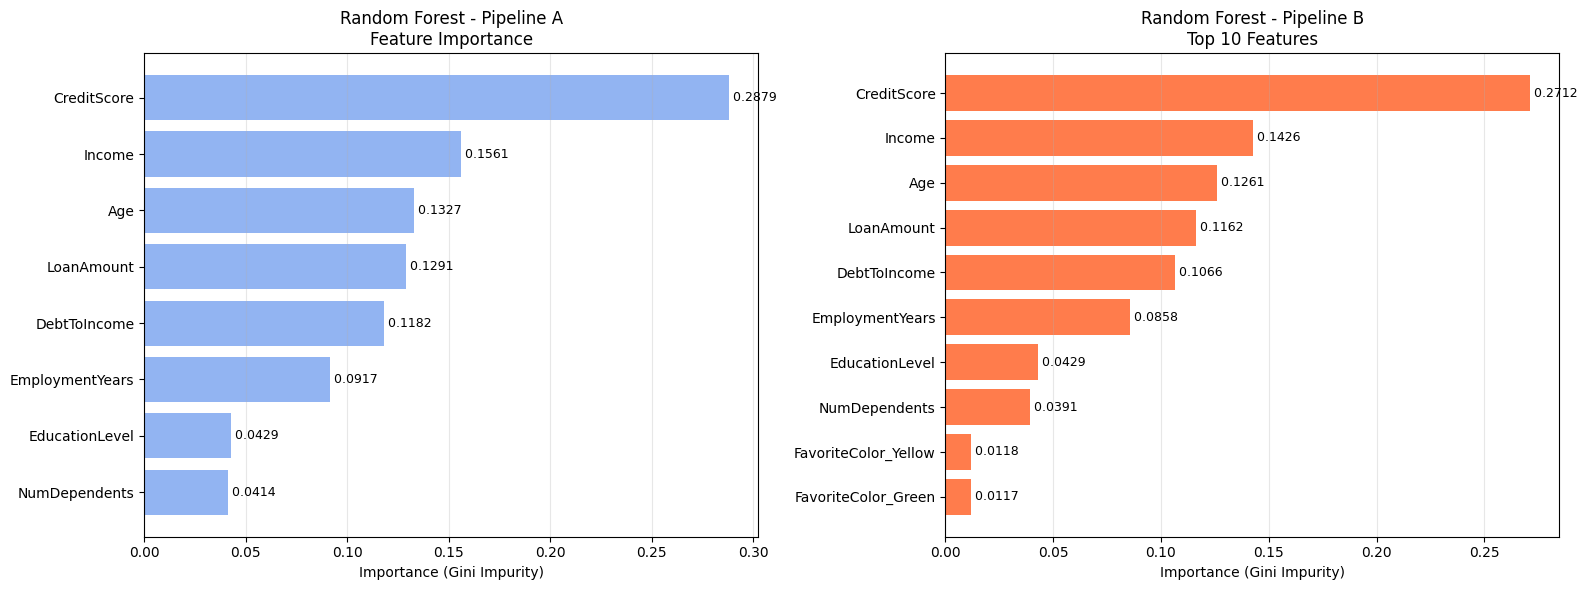


Feature importance plot saved to /Users/kryspin/personal/playground/recruitment/challengING_DS/ing_task/output/figures/03_rf_feature_importance.png

Categorical Feature Importance in Pipeline B:
  FavoriteColor_Green      : 0.011659
  FavoriteColor_Red        : 0.011294
  FavoriteColor_Yellow     : 0.011824
  Hobby_Reading            : 0.011620
  Hobby_Sports             : 0.011580
  Hobby_Traveling          : 0.011537

Total categorical importance: 0.0695 (6.95%)


In [15]:
print("=" * 80)
print("RANDOM FOREST FEATURE IMPORTANCE ANALYSIS")
print("=" * 80)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# pipeline A feature importance
importance_A = pd.DataFrame({
    'Feature': feature_names_A,
    'Importance': rf_A.feature_importances_
}).sort_values('Importance', ascending=True)

axes[0].barh(importance_A['Feature'], importance_A['Importance'], 
             color=Color.BLUE.value, alpha=0.7)
axes[0].set_xlabel('Importance (Gini Impurity)')
axes[0].set_title('Random Forest - Pipeline A\nFeature Importance')
axes[0].grid(True, alpha=0.3, axis='x')

# add values on bars
for idx, (feat, imp) in enumerate(zip(importance_A['Feature'], importance_A['Importance'])):
    axes[0].text(imp, idx, f' {imp:.4f}', va='center', fontsize=9)

# pipeline B feature importance (top 10)
importance_B = pd.DataFrame({
    'Feature': feature_names_B,
    'Importance': rf_B.feature_importances_
}).sort_values('Importance', ascending=False).head(10)

axes[1].barh(range(len(importance_B)), importance_B['Importance'], 
             color=Color.RED.value, alpha=0.7)
axes[1].set_yticks(range(len(importance_B)))
axes[1].set_yticklabels(importance_B['Feature'])
axes[1].set_xlabel('Importance (Gini Impurity)')
axes[1].set_title('Random Forest - Pipeline B\nTop 10 Features')
axes[1].grid(True, alpha=0.3, axis='x')
axes[1].invert_yaxis()

# add values on bars
for idx, (feat, imp) in enumerate(zip(importance_B['Feature'], importance_B['Importance'])):
    axes[1].text(imp, idx, f' {imp:.4f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig(FIGURES_DIR / '03_rf_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nFeature importance plot saved to {FIGURES_DIR / '03_rf_feature_importance.png'}")

# check if categorical features are low importance in Pipeline B
print("\nCategorical Feature Importance in Pipeline B:")
cat_features = [f for f in feature_names_B if 'FavoriteColor' in f or 'Hobby' in f]
for feat in cat_features:
    idx = feature_names_B.index(feat)
    imp = rf_B.feature_importances_[idx]
    print(f"  {feat:25s}: {imp:.6f}")

total_cat_importance = sum(rf_B.feature_importances_[feature_names_B.index(f)] 
                           for f in cat_features)
print(f"\nTotal categorical importance: {total_cat_importance:.4f} ({total_cat_importance*100:.2f}%)")

RANDOM FOREST: PIPELINE A vs B COMPARISON

ROC-AUC Comparison:
  Pipeline A (CV):   0.7904 ± 0.0109
  Pipeline B (CV):   0.7927 ± 0.0117
  Difference (CV):   0.0023

  Pipeline A (Test): 0.7869
  Pipeline B (Test): 0.7887
  Difference (Test): 0.0018

Paired t-test (CV folds):
  H₀: Pipeline A = Pipeline B
  t-statistic: -2.2263
  p-value:     0.0900
  Result:      No significant difference (p > 0.05)

Improvement over Logistic Regression:
  Pipeline A: 0.7869 vs 0.7590 = +0.0279 (3.7%)
  Pipeline B: 0.7887 vs 0.7590 = +0.0297 (3.9%)


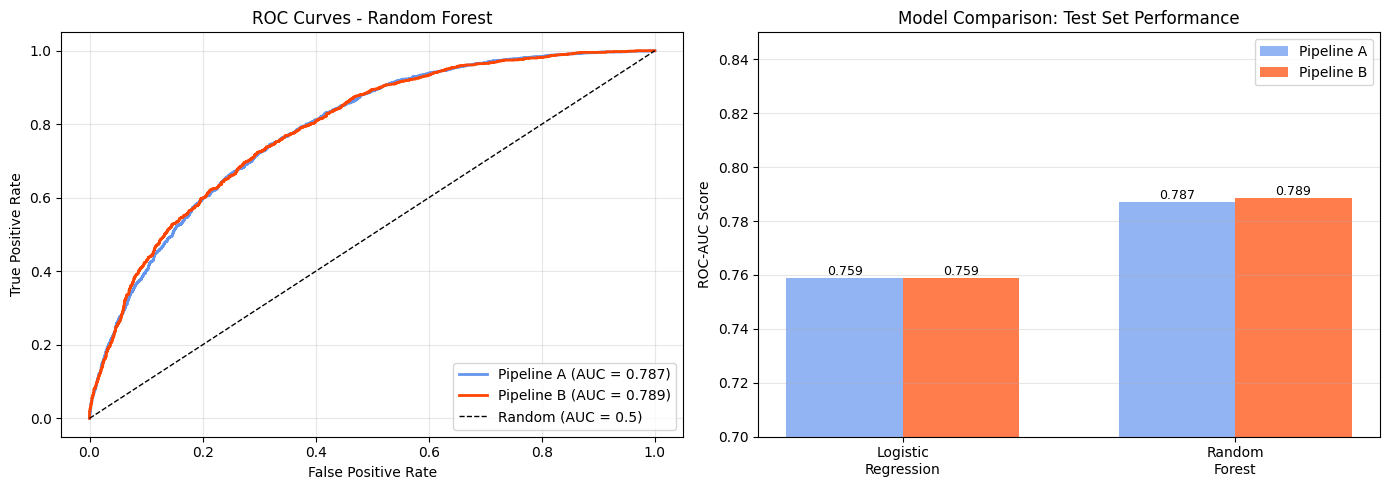


Comparison plots saved to /Users/kryspin/personal/playground/recruitment/challengING_DS/ing_task/output/figures/03_rf_comparison.png


In [16]:
print("=" * 80)
print("RANDOM FOREST: PIPELINE A vs B COMPARISON")
print("=" * 80)

# extract ROC-AUC scores
auc_A_cv = results_rf_A['cv_scores']['test_roc_auc']
auc_B_cv = results_rf_B['cv_scores']['test_roc_auc']
auc_A_test = results_rf_A['test_metrics']['roc_auc']
auc_B_test = results_rf_B['test_metrics']['roc_auc']

print("\nROC-AUC Comparison:")
print(f"  Pipeline A (CV):   {auc_A_cv.mean():.4f} ± {auc_A_cv.std():.4f}")
print(f"  Pipeline B (CV):   {auc_B_cv.mean():.4f} ± {auc_B_cv.std():.4f}")
print(f"  Difference (CV):   {abs(auc_A_cv.mean() - auc_B_cv.mean()):.4f}")
print(f"\n  Pipeline A (Test): {auc_A_test:.4f}")
print(f"  Pipeline B (Test): {auc_B_test:.4f}")
print(f"  Difference (Test): {abs(auc_A_test - auc_B_test):.4f}")

# statistical test
t_stat, p_value = ttest_rel(auc_A_cv, auc_B_cv)

print(f"\nPaired t-test (CV folds):")
print(f"  H₀: Pipeline A = Pipeline B")
print(f"  t-statistic: {t_stat:.4f}")
print(f"  p-value:     {p_value:.4f}")
print(f"  Result:      {'No significant difference (p > 0.05)' if p_value > 0.05 else 'Significant difference (p < 0.05)'}")

# performance improvement over Logistic Regression
lr_A_auc = results_lr_A['test_metrics']['roc_auc']
lr_B_auc = results_lr_B['test_metrics']['roc_auc']

print(f"\nImprovement over Logistic Regression:")
print(f"  Pipeline A: {auc_A_test:.4f} vs {lr_A_auc:.4f} = +{(auc_A_test - lr_A_auc):.4f} ({(auc_A_test - lr_A_auc)/lr_A_auc*100:.1f}%)")
print(f"  Pipeline B: {auc_B_test:.4f} vs {lr_B_auc:.4f} = +{(auc_B_test - lr_B_auc):.4f} ({(auc_B_test - lr_B_auc)/lr_B_auc*100:.1f}%)")

# vis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC curves
colors = [Color.BLUE.value, Color.RED.value]
for idx, (key, pipeline, color) in enumerate([
    ('rf_A', 'A', Color.BLUE.value),
    ('rf_B', 'B', Color.RED.value)
]):
    results = all_results[key]
    fpr, tpr, _ = roc_curve(y_test, results['y_pred_proba'])
    auc = results['test_metrics']['roc_auc']
    
    axes[0].plot(fpr, tpr, color=color, lw=2, 
                 label=f'Pipeline {pipeline} (AUC = {auc:.3f})')

axes[0].plot([0, 1], [0, 1], 'k--', lw=1, label='Random (AUC = 0.5)')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curves - Random Forest')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# model comparison: LR vs RF
models = ['Logistic\nRegression', 'Random\nForest']
pipeline_A_scores = [lr_A_auc, auc_A_test]
pipeline_B_scores = [lr_B_auc, auc_B_test]

x = np.arange(len(models))
width = 0.35

bars1 = axes[1].bar(x - width/2, pipeline_A_scores, width, 
                    label='Pipeline A', color=Color.BLUE.value, alpha=0.7)
bars2 = axes[1].bar(x + width/2, pipeline_B_scores, width,
                    label='Pipeline B', color=Color.RED.value, alpha=0.7)

axes[1].set_ylabel('ROC-AUC Score')
axes[1].set_title('Model Comparison: Test Set Performance')
axes[1].set_xticks(x)
axes[1].set_xticklabels(models)
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_ylim([0.70, 0.85])

# add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(FIGURES_DIR / '03_rf_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nComparison plots saved to {FIGURES_DIR / '03_rf_comparison.png'}")

In [17]:
print("=" * 80)
print("XGBOOST PREPARATION")
print("=" * 80)

# calc scale_pos_weight for class imbalance
# XGBoost uses this to weight positive class
n_negative = (y_train == 0).sum()
n_positive = (y_train == 1).sum()
scale_pos_weight = n_negative / n_positive

print(f"\nClass distribution:")
print(f"  Negative (0): {n_negative:,} ({n_negative/len(y_train)*100:.2f}%)")
print(f"  Positive (1): {n_positive:,} ({n_positive/len(y_train)*100:.2f}%)")
print(f"\nScale_pos_weight: {scale_pos_weight:.4f}")
print(f"  (Ratio of negative to positive samples)")

print("\nXGBoost class weight calculated")

XGBOOST PREPARATION

Class distribution:
  Negative (0): 13,137 (65.69%)
  Positive (1): 6,863 (34.31%)

Scale_pos_weight: 1.9142
  (Ratio of negative to positive samples)

XGBoost class weight calculated


In [18]:
print("=" * 80)
print("MODEL 7/8: XGBOOST - PIPELINE A")
print("=" * 80)

# create and train model
xgb_A = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    random_state=RANDOM_SEED,
    n_jobs=-1,
    eval_metric='logloss',
    use_label_encoder=False  # suppress warning
)

print("Training XGBoost (100 boosting rounds)...")
xgb_A.fit(X_train_A, y_train, verbose=False)

# eval
results_xgb_A = evaluate_model(
    model=xgb_A,
    X_train=X_train_A,
    y_train=y_train,
    X_test=X_test_A,
    y_test=y_test,
    cv=cv,
    model_name='XGBoost',
    pipeline_name='A'
)

all_results['xgb_A'] = results_xgb_A

# display results
print("\nCross-Validation Results (5-fold):")
for metric in ['roc_auc', 'f1', 'precision', 'recall', 'accuracy']:
    scores = results_xgb_A['cv_scores'][f'test_{metric}']
    print(f"  {metric:12s}: {scores.mean():.4f} ± {scores.std():.4f}")

print("\nTest Set Results:")
for metric, value in results_xgb_A['test_metrics'].items():
    print(f"  {metric:12s}: {value:.4f}")

# feature importance (gain)
print("\nFeature Importance (Gain - Top 8):")
importance_df = pd.DataFrame({
    'Feature': feature_names_A,
    'Importance': xgb_A.feature_importances_
}).sort_values('Importance', ascending=False)
print(importance_df.to_string(index=False))

print("\nModel 7/8 complete")

MODEL 7/8: XGBOOST - PIPELINE A
Training XGBoost (100 boosting rounds)...

Cross-Validation Results (5-fold):
  roc_auc     : 0.7966 ± 0.0099
  f1          : 0.6364 ± 0.0097
  precision   : 0.5660 ± 0.0069
  recall      : 0.7271 ± 0.0190
  accuracy    : 0.7150 ± 0.0060

Test Set Results:
  roc_auc     : 0.7967
  f1          : 0.6459
  precision   : 0.5743
  recall      : 0.7381
  accuracy    : 0.7152
  brier       : 0.1841

Feature Importance (Gain - Top 8):
        Feature  Importance
    CreditScore    0.352856
            Age    0.162745
 EducationLevel    0.159567
         Income    0.110507
     LoanAmount    0.063157
   DebtToIncome    0.054037
EmploymentYears    0.050091
  NumDependents    0.047041

Model 7/8 complete


In [19]:
print("=" * 80)
print("MODEL 8/8: XGBOOST - PIPELINE B")
print("=" * 80)

# create and train model
xgb_B = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    random_state=RANDOM_SEED,
    n_jobs=-1,
    eval_metric='logloss',
    use_label_encoder=False
)

print("Training XGBoost (100 boosting rounds)...")
xgb_B.fit(X_train_B, y_train, verbose=False)

# eval
results_xgb_B = evaluate_model(
    model=xgb_B,
    X_train=X_train_B,
    y_train=y_train,
    X_test=X_test_B,
    y_test=y_test,
    cv=cv,
    model_name='XGBoost',
    pipeline_name='B'
)

# Store results
all_results['xgb_B'] = results_xgb_B

# Display results
print("\nCross-Validation Results (5-fold):")
for metric in ['roc_auc', 'f1', 'precision', 'recall', 'accuracy']:
    scores = results_xgb_B['cv_scores'][f'test_{metric}']
    print(f"  {metric:12s}: {scores.mean():.4f} ± {scores.std():.4f}")

print("\nTest Set Results:")
for metric, value in results_xgb_B['test_metrics'].items():
    print(f"  {metric:12s}: {value:.4f}")

# Feature importance
print("\nFeature Importance (Gain - Top 14):")
importance_df = pd.DataFrame({
    'Feature': feature_names_B,
    'Importance': xgb_B.feature_importances_
}).sort_values('Importance', ascending=False)
print(importance_df.to_string(index=False))

print("\n✓ Model 8/8 complete")
print("\n" + "=" * 80)
print("ALL MODELS TRAINED (8/8)")
print("=" * 80)

MODEL 8/8: XGBOOST - PIPELINE B
Training XGBoost (100 boosting rounds)...

Cross-Validation Results (5-fold):
  roc_auc     : 0.7976 ± 0.0109
  f1          : 0.6354 ± 0.0092
  precision   : 0.5655 ± 0.0067
  recall      : 0.7253 ± 0.0177
  accuracy    : 0.7145 ± 0.0058

Test Set Results:
  roc_auc     : 0.7979
  f1          : 0.6425
  precision   : 0.5672
  recall      : 0.7409
  accuracy    : 0.7098
  brier       : 0.1839

Feature Importance (Gain - Top 14):
             Feature  Importance
         CreditScore    0.286605
                 Age    0.129306
      EducationLevel    0.116907
              Income    0.087216
          LoanAmount    0.049099
        DebtToIncome    0.040531
       Hobby_Reading    0.040165
 FavoriteColor_Green    0.039107
     EmploymentYears    0.039049
FavoriteColor_Yellow    0.037847
   FavoriteColor_Red    0.036041
       NumDependents    0.035031
     Hobby_Traveling    0.033001
        Hobby_Sports    0.030095

✓ Model 8/8 complete

ALL MODELS TRAINED

XGBOOST FEATURE IMPORTANCE ANALYSIS


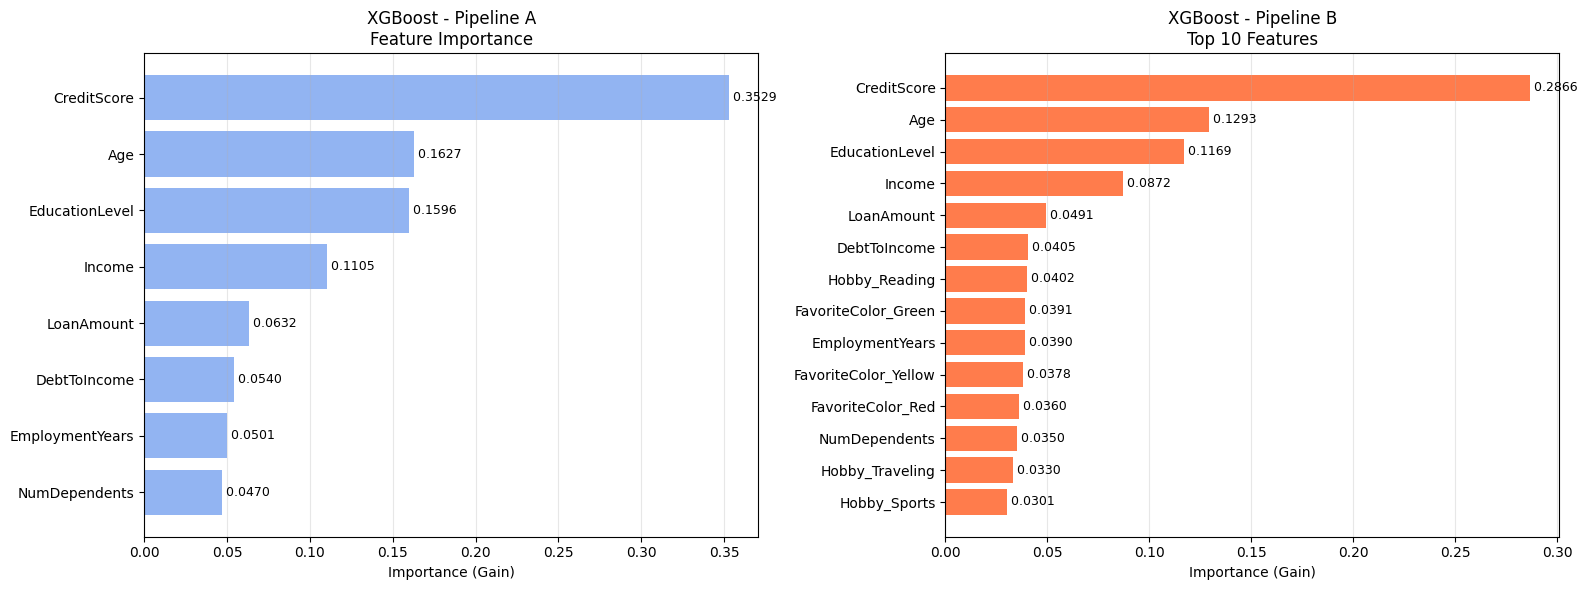


Feature importance plot saved to /Users/kryspin/personal/playground/recruitment/challengING_DS/ing_task/output/figures/03_xgb_feature_importance.png

Categorical Feature Importance in Pipeline B:
  FavoriteColor_Green      : 0.039107
  FavoriteColor_Red        : 0.036041
  FavoriteColor_Yellow     : 0.037847
  Hobby_Reading            : 0.040165
  Hobby_Sports             : 0.030095
  Hobby_Traveling          : 0.033001

Total categorical importance: 0.2163 (21.63%)


In [23]:
print("=" * 80)
print("XGBOOST FEATURE IMPORTANCE ANALYSIS")
print("=" * 80)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# pipeline A feature importance
importance_A = pd.DataFrame({
    'Feature': feature_names_A,
    'Importance': xgb_A.feature_importances_
}).sort_values('Importance', ascending=True)

axes[0].barh(importance_A['Feature'], importance_A['Importance'], 
             color=Color.BLUE.value, alpha=0.7)
axes[0].set_xlabel('Importance (Gain)')
axes[0].set_title('XGBoost - Pipeline A\nFeature Importance')
axes[0].grid(True, alpha=0.3, axis='x')

# add values on bars
for idx, (feat, imp) in enumerate(zip(importance_A['Feature'], importance_A['Importance'])):
    axes[0].text(imp, idx, f' {imp:.4f}', va='center', fontsize=9)

# pipeline B feature importance
importance_B = pd.DataFrame({
    'Feature': feature_names_B,
    'Importance': xgb_B.feature_importances_
}).sort_values('Importance', ascending=False)

axes[1].barh(range(len(importance_B)), importance_B['Importance'], 
             color=Color.RED.value, alpha=0.7)
axes[1].set_yticks(range(len(importance_B)))
axes[1].set_yticklabels(importance_B['Feature'])
axes[1].set_xlabel('Importance (Gain)')
axes[1].set_title('XGBoost - Pipeline B\nTop 10 Features')
axes[1].grid(True, alpha=0.3, axis='x')
axes[1].invert_yaxis()

# add values on bars
for idx, (feat, imp) in enumerate(zip(importance_B['Feature'], importance_B['Importance'])):
    axes[1].text(imp, idx, f' {imp:.4f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig(FIGURES_DIR / '03_xgb_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nFeature importance plot saved to {FIGURES_DIR / '03_xgb_feature_importance.png'}")

# check categorical features importance
print("\nCategorical Feature Importance in Pipeline B:")
cat_features = [f for f in feature_names_B if 'FavoriteColor' in f or 'Hobby' in f]
for feat in cat_features:
    idx = feature_names_B.index(feat)
    imp = xgb_B.feature_importances_[idx]
    print(f"  {feat:25s}: {imp:.6f}")

total_cat_importance = sum(xgb_B.feature_importances_[feature_names_B.index(f)] 
                           for f in cat_features)
print(f"\nTotal categorical importance: {total_cat_importance:.4f} ({total_cat_importance*100:.2f}%)")

XGBOOST: PIPELINE A vs B COMPARISON

ROC-AUC Comparison:
  Pipeline A (CV):   0.7966 ± 0.0099
  Pipeline B (CV):   0.7976 ± 0.0109
  Difference (CV):   0.0010

  Pipeline A (Test): 0.7967
  Pipeline B (Test): 0.7979
  Difference (Test): 0.0012

Paired t-test (CV folds):
  H_0: Pipeline A = Pipeline B
  t-statistic: -2.0072
  p-value:     0.1152
  Result:      No significant difference (p > 0.05)

Improvement over Random Forest:
  Pipeline A: 0.7967 vs 0.7869 = +0.0099 (1.3%)
  Pipeline B: 0.7979 vs 0.7887 = +0.0092 (1.2%)


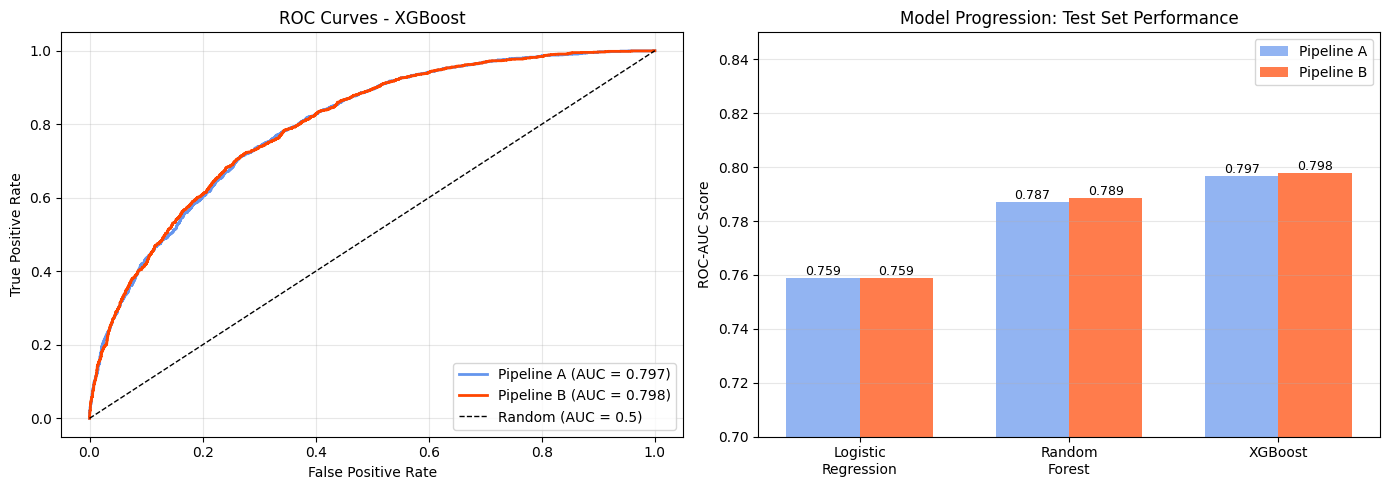


Comparison plots saved to /Users/kryspin/personal/playground/recruitment/challengING_DS/ing_task/output/figures/03_xgb_comparison.png

✓ Section E Complete - XGBoost (All Models Trained)


In [26]:
print("=" * 80)
print("XGBOOST: PIPELINE A vs B COMPARISON")
print("=" * 80)

# extract ROC-AUC scores
auc_A_cv = results_xgb_A['cv_scores']['test_roc_auc']
auc_B_cv = results_xgb_B['cv_scores']['test_roc_auc']
auc_A_test = results_xgb_A['test_metrics']['roc_auc']
auc_B_test = results_xgb_B['test_metrics']['roc_auc']

print("\nROC-AUC Comparison:")
print(f"  Pipeline A (CV):   {auc_A_cv.mean():.4f} ± {auc_A_cv.std():.4f}")
print(f"  Pipeline B (CV):   {auc_B_cv.mean():.4f} ± {auc_B_cv.std():.4f}")
print(f"  Difference (CV):   {abs(auc_A_cv.mean() - auc_B_cv.mean()):.4f}")
print(f"\n  Pipeline A (Test): {auc_A_test:.4f}")
print(f"  Pipeline B (Test): {auc_B_test:.4f}")
print(f"  Difference (Test): {abs(auc_A_test - auc_B_test):.4f}")

# statistical test
t_stat, p_value = ttest_rel(auc_A_cv, auc_B_cv)

print(f"\nPaired t-test (CV folds):")
print(f"  H_0: Pipeline A = Pipeline B")
print(f"  t-statistic: {t_stat:.4f}")
print(f"  p-value:     {p_value:.4f}")
print(f"  Result:      {'No significant difference (p > 0.05)' if p_value > 0.05 else 'Significant difference (p < 0.05)'}")

# performance improvement over Random Forest
rf_A_auc = results_rf_A['test_metrics']['roc_auc']
rf_B_auc = results_rf_B['test_metrics']['roc_auc']

print(f"\nImprovement over Random Forest:")
print(f"  Pipeline A: {auc_A_test:.4f} vs {rf_A_auc:.4f} = {'+' if auc_A_test > rf_A_auc else ''}{(auc_A_test - rf_A_auc):.4f} ({(auc_A_test - rf_A_auc)/rf_A_auc*100:.1f}%)")
print(f"  Pipeline B: {auc_B_test:.4f} vs {rf_B_auc:.4f} = {'+' if auc_B_test > rf_B_auc else ''}{(auc_B_test - rf_B_auc):.4f} ({(auc_B_test - rf_B_auc)/rf_B_auc*100:.1f}%)")

# vis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC curves
for idx, (key, pipeline, color) in enumerate([
    ('xgb_A', 'A', Color.BLUE.value),
    ('xgb_B', 'B', Color.RED.value)
]):
    results = all_results[key]
    fpr, tpr, _ = roc_curve(y_test, results['y_pred_proba'])
    auc = results['test_metrics']['roc_auc']
    
    axes[0].plot(fpr, tpr, color=color, lw=2, 
                 label=f'Pipeline {pipeline} (AUC = {auc:.3f})')

axes[0].plot([0, 1], [0, 1], 'k--', lw=1, label='Random (AUC = 0.5)')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curves - XGBoost')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# Model progression comparison
models = ['Logistic\nRegression', 'Random\nForest', 'XGBoost']
pipeline_A_scores = [
    results_lr_A['test_metrics']['roc_auc'],
    results_rf_A['test_metrics']['roc_auc'],
    auc_A_test
]
pipeline_B_scores = [
    results_lr_B['test_metrics']['roc_auc'],
    results_rf_B['test_metrics']['roc_auc'],
    auc_B_test
]

x = np.arange(len(models))
width = 0.35

bars1 = axes[1].bar(x - width/2, pipeline_A_scores, width, 
                    label='Pipeline A', color=Color.BLUE.value, alpha=0.7)
bars2 = axes[1].bar(x + width/2, pipeline_B_scores, width,
                    label='Pipeline B', color=Color.RED.value, alpha=0.7)

axes[1].set_ylabel('ROC-AUC Score')
axes[1].set_title('Model Progression: Test Set Performance')
axes[1].set_xticks(x)
axes[1].set_xticklabels(models)
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_ylim([0.70, 0.85])
axes[1].axhline(y=0.5, color='gray', linestyle='--', alpha=0.3, label='Random')

# add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(FIGURES_DIR / '03_xgb_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nComparison plots saved to {FIGURES_DIR / '03_xgb_comparison.png'}")
print("\n✓ Section E Complete - XGBoost (All Models Trained)")